In [48]:
import apgpy as apg
import numpy as np
import matplotlib.pyplot as plt
from apgwrapper import IWrapper
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [49]:
# this is not a good way to wrap the data for cone programs
# it's just to illustrate how to use the IWrapper interface
class ConeProgWrapper(IWrapper):
    def __init__(self, vardict):
        self.__dict__ = vardict # vardict = {'x':x, 's':s,'y':y, 'r': r,'t':tau,'k':k}
    
    def get(self, name):
        return self.__dict__[name]
    
    def dot(self, other):
        return sum({i : np.inner(self.get(i), other.get(i)) for i in self.__dict__}.values())

    def __add__(self, other):
        return ConeProgWrapper({i : self.get(i) + other.get(i) for i in self.__dict__})

    def __sub__(self, other):
        return ConeProgWrapper({i : self.get(i) - other.get(i) for i in self.__dict__})

    def __mul__(self, scalar):
        return ConeProgWrapper({i : self.get(i) * scalar for i in self.__dict__})

    def copy(self):
        return ConeProgWrapper({i : np.copy(self.get(i)) for i in self.__dict__})

    def norm(self):
        return np.sqrt(sum(np.linalg.norm(value)**2 for value in self.__dict__.itervalues()))

    __rmul__ = __mul__


In [50]:
n = 100
m = 300
A = np.random.randn(m, n)
z = np.random.randn(m)
y = np.maximum(z, 0)
s = y - z
x = np.random.randn(n)

c = -np.dot(A.T, y)
b = np.dot(A,x) + s

Q = np.row_stack((np.column_stack((np.zeros((n,n)), A.T, c)), 
                  np.column_stack((-A, np.zeros((m,m)), b)), 
                  np.hstack((-c.T, -b.T, 0))))

np.inner(c,x)

-89.154704130323893

In [51]:
def quad_grad(d):
    Qu_v = np.dot(Q, np.hstack((d.x,d.y,d.t))) - np.hstack((d.r,d.s,d.k))
    g = np.hstack((np.dot(Q.T, Qu_v),-Qu_v))
    return ConeProgWrapper({'x': g[:n], 'y':g[n:n+m],'t':g[n+m], 'r':g[n+m+1:m+2*n+1], 's':g[m+2*n+1:2*m+2*n+1], 'k':g[2*m+2*n+1]})

In [52]:
def proj_cone(d, t):
    d.r = np.zeros(n)
    d.s = np.maximum(d.s, 0)
    d.y = np.maximum(d.y, 0)
    d.t = np.maximum(d.t, 0)
    d.k = np.maximum(d.k, 0)
    return d

In [53]:
initialpt = ConeProgWrapper({'x':np.zeros(n), 's':np.zeros(m), 'y':np.zeros(m), 'r': np.zeros(n), 't':1., 'k':1.})

-89.15407912152979

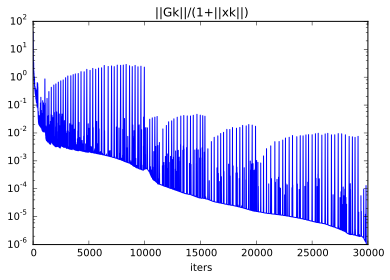

In [60]:
u = apg.solve(quad_grad, proj_cone, initialpt, use_restart=True, alpha=1.001, max_iters=50000, quiet=True, gen_plots=True)
x_apg = u.x / u.t
np.dot(c, x_apg)

In [61]:
import cvxpy as cp

z = cp.Variable(n)
objective = cp.Minimize(c * z)
constraints = [A * z - b <= 0]
p = cp.Problem(objective, constraints)
p.solve(verbose=True, solver=cp.SCS, eps=1e-8)
x_scs = z.value.A1


----------------------------------------------------------------------------
	SCS v1.1.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 30000
eps = 1.00e-08, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 100, constraints m = 300
Cones:	linear vars: 300
Setup time: 5.49e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.47e+00  1.44e+00  7.34e-01 -1.72e+03 -2.63e+02  5.56e-13  1.18e-03 
   100| 9.14e-04  5.43e-04  3.64e-04 -8.92e+01 -8.92e+01  2.11e-13  9.14e-03 
   200| 1.51e-04  4.78e-05  1.08e-04 -8.92e+01 -8.92e+01  2.11e-13  1.73e-02 
   300| 1.20e-04  2.56e-05  8.74e-05 -8.91e+01 -8.92e+01  2.11e-13  2.53e-02 
   400| 3.06e

In [62]:
np.linalg.norm(x - x_scs)

6.5596675989349298e-07

In [63]:
np.linalg.norm(x - x_apg)

0.00033659229975780672